## 1.1 텐서플로우 허브
- Tensorflow Hub : https://tfhub.dev/

In [1]:
import tensorflow as tf
import tensorflow_hub as hub

print(tf.__version__)

2.3.0


## 1.2 사전 훈련 모델 불러오기 - MobileNet

In [2]:
# tensorflow hub 에서 사전 훈련된 모델 불러오기
# MobileNet : 계산 부담이 큰 합성곱 신경망을 연산 능력이 제한된 모바일 환경에서도 작동 가능할 정도로 네트워크 구조를 경량화한 구조
# ResNet-50(2560만 개) : ResNet-12(6000만 개)에 비해 파라미터 수가 상대적으로 적음 

mobile_net_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" 
model = tf.keras.Sequential([hub.KerasLayer(handle=mobile_net_url, 
                                            input_shape=(224, 224, 3))]) # input_shape : 입력할 이미지의 크기
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              3540265   
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


14540800/14536120 [==============================] - 0s 0us/step


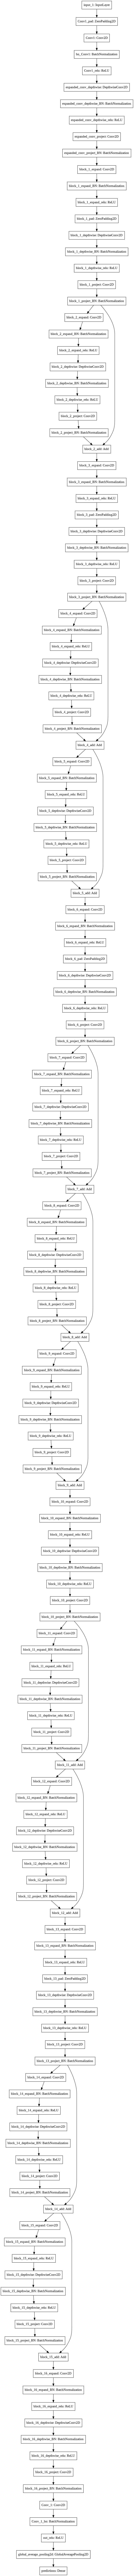

In [3]:
# ImageNet 데이터로 학습
# Imagenet에는 1000 종류의 이미지가 존재 (1 ~ 1000)
# 만약 어떠한 것도 분류되지 않는다면, 인덱스 0 (background) 값을 반환

from tensorflow.keras.applications import MobileNetV2 # MobileNet_V2 : 기존 버전에서 일부만 모아 크기를 줄인 것

mobilev2 = MobileNetV2()
tf.keras.utils.plot_model(mobilev2)

## 1.3 ImageNet_V2

In [4]:
# MobileNet 성능 평가
# ImageNet_V2를 사용하여 평가를 진행 -> 클래스 별 각 10개 씩 (1000 * 10), 총 10000장의 사진이 포함되어 있는 'TopImages 데이터' 사용

import os
import pathlib

content_data_url = '/content/sample_data' # Colab 기본 경로를 변수화

# tf.keras.utils.get_file() : 사전에 저장되어 있는 데이터를 불러올 수 있는 함수
data_root_orig = tf.keras.utils.get_file(fname='imagenetV2', 
                                         origin='https://s3-us-west-2.amazonaws.com/imagenetv2public/imagenetv2-topimages.tar.gz', # origin : 저장 경로
                                         cache_dir=content_data_url, 
                                         extract=True) # extract=True : tar.gz 형식의 압축파일이 자동으로 해제되어 Colab 가상머신에 저장

data_root = pathlib.Path(content_data_url + '/datasets/imagenetv2-top-images-format-val') # Pathlib.Path() : 경로 설정 함수

print(data_root)

1234968576/1234964480 [==============================] - 63s 0us/step
/content/sample_data/datasets/imagenetv2-top-images-format-val


In [5]:
# 라벨 값들의 정보 불러오기

# 라벨 정보 불러오기
label_file = tf.keras.utils.get_file(fname='label',               
                                     origin='https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

label_text = None # 빈 객체 생성

with open(file=label_file, mode='r') as f: # text 파일 열고, '읽기 모드' 설정
    label_text = f.read().split('\n')[:-1] # 처음부터 끝 까지 읽으며 '\n'(줄 바꿈)을 기준으로 split

print(len(label_text))
print(label_text[:10])
print(label_text[-10:])

16384/10484 [==============================================] - 0s 0us/step
1001
['background', 'tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen']
['buckeye', 'coral fungus', 'agaric', 'gyromitra', 'stinkhorn', 'earthstar', 'hen-of-the-woods', 'bolete', 'ear', 'toilet tissue']


## 1.4 정확도 확인

In [6]:
# 이미지와 라벨링 값 랜덤 출력

import PIL.Image as Image
import matplotlib.pyplot as plt
import random

# listdir()은 해당 경로의 파일/디렉터리 이름만 가져오지만, glob()은 탐색한 경로까지 함께 가져온다.
all_image_paths = list(data_root.glob('*/*')) # '*/*' : 모든 경로 및 파일

all_image_paths = [str(path) for path in all_image_paths] # 위의 모든 경로 및 파일 명을 문자화 시켜서 변수에 할당

random.shuffle(all_image_paths) # 이미지를 랜덤하게 셔플

# 이미지의 총 수 확인
image_count = len(all_image_paths)
print('image_count:', image_count)

image_count: 10000


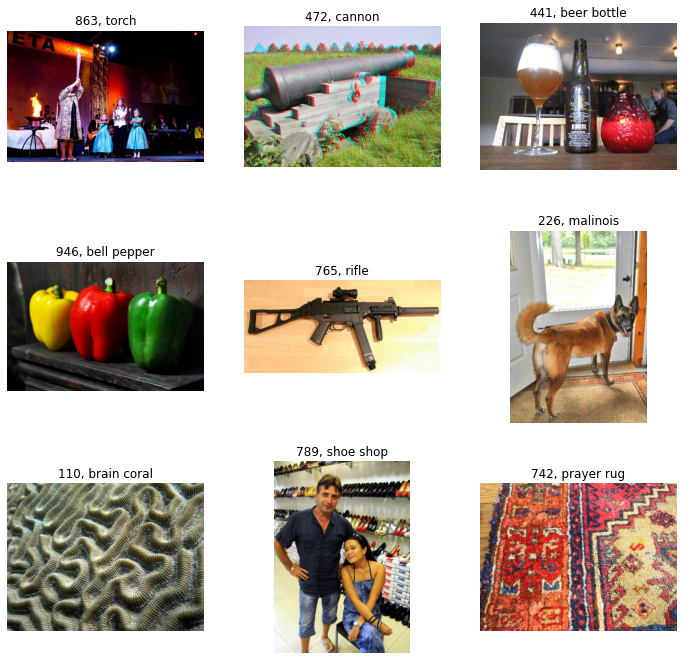

In [7]:
plt.figure(figsize=(12, 12))

for i in range(9):
    image_path = random.choice(all_image_paths) # 이미지를 랜덤으로 추출

    plt.subplot(3, 3, i+1) # 차례로 출력

    # 랜덤으로 선택된 사진 출력
    plt.imshow(plt.imread(image_path)) # plt.imshow() : 이미지 출력 / plt.imread() : 파일 읽어오기

    idx = int(image_path.split('/')[-2]) + 1 # 첫 번째 부터 1000번째 까지의 라벨과 텍스트가 동일한 값을 갖도록 코딩

    plt.title(str(idx) + ', ' + label_text[idx]) # 각 사진마다 라벨링 번호 + 라벨링 텍스트 출력

    plt.axis('off') # 각 사진마다 라벨링 번호 + 라벨링 텍스트 출력

plt.show()

In [8]:
# MobileNet 정확도 확인
# Top-5 정확도 : 전통적으로 ImageNet 대회에서는 신경망이 예측하는 값 중 상위 5개 이내에 데이터의 실제 분류가 포함돼 있으면 정답 인정
# Top-1 정확도 : 신경망이 예측하는 값 중 상위 1개 이내에 데이터의 실제 분류가 포함돼 있으면 정답으로 인정
# 최초의 MobileNet 버전의 Top-5 : 89.9& / Top-1 : 70.9% (참고 문헌 : http://bit.ly/2kzUU1F)

import cv2
import numpy as np

# 빈 객체 생성
top_1, top_5 = 0, 0

for image_path in all_image_paths: # all_image_paths에 저장되어 있는 경로를 하나씩 불러오며 반복
    img = cv2.imread(image_path) # cv2.imread() : 사진 읽어들이기
    img = cv2.resize(img, dsize=(224, 224)) # cv2.resize() : 사진 크기 재조정 (픽셀 통일)
    img = img / 255.0 # 최소-최대 정규화
    img = np.expand_dims(img, axis=0) # np.expand_dims(axis=0) : 첫 번째 자원 추가 -> 채널 추가

    # 예측 값에 대한 순위 정보[0]를 argsort()로 index 정렬 (오름차순)
    # [::-1][:5] : Extended Slices 기법으로 내림차순으로 변경, 그 중 Top 5
    top_5_predict = model.predict(img)[0].argsort()[::-1][:5]
    idx = int(image_path.split('/')[-2])+1 # 라벨링 번호 도출 (인덱스를 1부터 부여했기 때문에 +1)

    # 신경망은 반복문을 타고 넘어온 n번째 img를 가지고 예측을 수행해서 5개의 Top 후보 (top_5_predict)를 추렸다.
    if idx in top_5_predict: # 만약 이 n 번째 img가 신경망이 가장 높게 예측한 후보 5개 안에 들어있다면,
        top_5 += 1 # top_5 에 1 을 추가
        if top_5_predict[0] == idx: # 또 만약 가장 높게 예측한[0] 것과 idx가 같다면,
            top_1 += 1 # top_1 에 1 을 추가

# 최종 출력 (정확도 측정) : 정확하게 예측한 경우 / 전체 사진 수
print('TOP - 5 정확성 :', top_5 / len(all_image_paths) * 100, '%')
print('TOP - 1 정확성 :', top_1 / len(all_image_paths) * 100, '%')

TOP - 5 정확성 : 83.3 %
TOP - 1 정확성 : 58.76 %


In [9]:
# Softmax 개선식 적용 : overflow 문제 해결, 0 나눗셈 문제 해결
def softmax(x):
    max_elem = np.max(x)
    diff = (x - max_elem)
    exp = np.exp(diff)
    sum_exp = np.sum(exp)
    probs = (exp / sum_exp)
    return probs

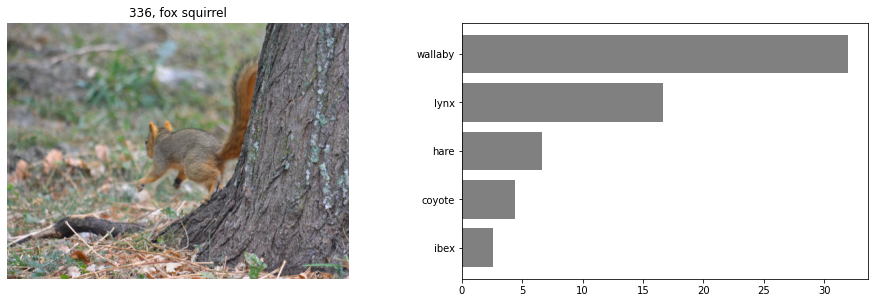

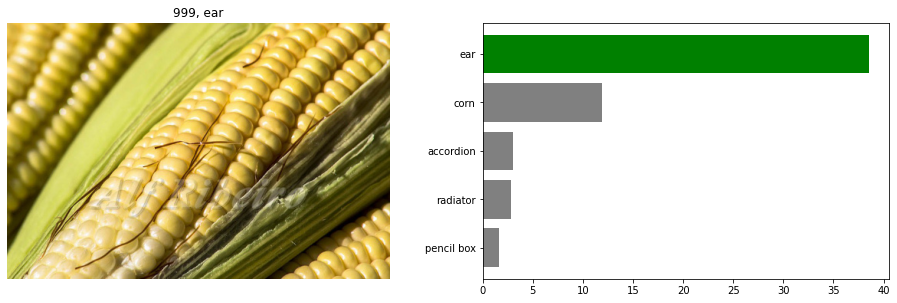

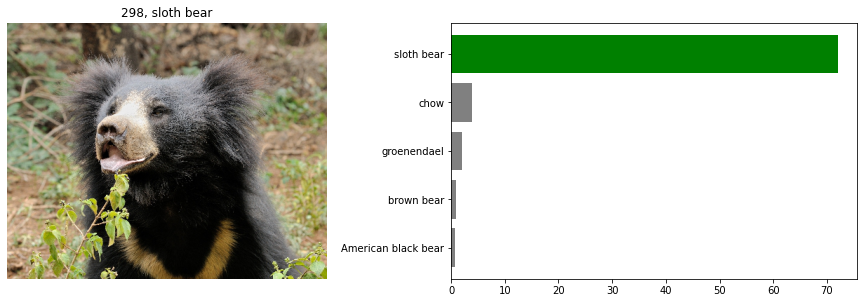

In [10]:
for c in range(3): # 3 개에 대한 결과 표시
    image_path = random.choice(all_image_paths)

    plt.figure(figsize=(16, 16))
    
    plt.subplot(3, 2, c*2+1) # 이미지 표시 (행, 열, 좌측(1, 3, 5))
    plt.imshow(plt.imread(image_path)) # 이미지 출력
    idx = int(image_path.split('/')[-2]) + 1 # 이미지 번호 변수화
    plt.title(str(idx) + ', ' + label_text[idx]) # 번호 + 라벨링 출력
    plt.axis('off')

    plt.subplot(3, 2, c*2+2) # 예측값 표시 (행, 열, 우측(2, 4, 6))
    img = cv2.imread(image_path) # 이미지 읽어들이기
    img = cv2.resize(img, dsize=(224, 224)) # 이미지 크기 통일
    img = img / 255.0 # 이미지 정규화
    img = np.expand_dims(img, axis=0) # 차원 추가

    logits = model.predict(img)[0] # MobileNet을 이용해 예측한 값을 logit값으로 저장
    prediction = softmax(logits) # 직접 정의한 softmax()를 이용하여 예측 확률 출력

    top_5_predict = prediction.argsort()[::-1][:5] # 가장 높은 확률의 예측값 5개를 뽑음
    labels = [label_text[index] for index in top_5_predict] # 신경망 예측 결과인 top_5_predict(숫자)를 가지고 라벨링 명으로 변환
    color = ['gray'] * 5 

    if idx in top_5_predict: # 만약 idx가 예측값 안에 있다면,
        # top_5_predict를 tolist()로 리스트화 시키고, 그 안에 있는 idx를 인덱스화 시켜준 다음, 'x색'을 바꿔준다.
        color[top_5_predict.tolist().index(idx)] = 'green' 
    
    color = color[::-1] # 내림차순으로 변경 -> 즉, 가장 상단에 'x색'이 오도록

    plt.barh(range(5), prediction[top_5_predict][::-1] * 100, color = color) # plt.barh() : 가로 막대 그리기

    plt.yticks(range(5), labels[::-1]) # plt.yticks() : y축의 '틱' 정보 표시